In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import xarray as xr

import pyproj
import pygmt

import euler

In [2]:
data_dir = pathlib.Path("..") / "data"
data = xr.load_dataset(data_dir / "rio-de-janeiro-magnetic.nc")
data

<xarray.Dataset> Size: 3MB
Dimensions:              (northing: 267, easting: 306)
Coordinates:
  * easting              (easting) float64 2kB -4.399e+06 ... -4.323e+06
  * northing             (northing) float64 2kB -2.379e+06 ... -2.313e+06
Data variables:
    total_field_anomaly  (northing, easting) float64 654kB 178.2 178.7 ... 66.18
    height               (northing, easting) float64 654kB 300.0 300.0 ... 300.0
    deriv_east           (northing, easting) float64 654kB 0.002006 ... -0.00...
    deriv_north          (northing, easting) float64 654kB 0.009078 ... 0.006171
    deriv_up             (northing, easting) float64 654kB -0.02584 ... -0.015
Attributes:
    metadata:  Generated by EquivalentSourcesGB(block_size=250, damping=10.0,...

# Euler Inversion

In [3]:
window_size = 10e3
window_step = window_size / 2

In [4]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.2,
).fit_grid(
    data,
    data_names=("total_field_anomaly", "deriv_east", "deriv_north", "deriv_up"),
    coordinate_names=("easting", "northing", "height"),
)

CPU times: user 196 ms, sys: 137 ms, total: 333 ms
Wall time: 1.65 s


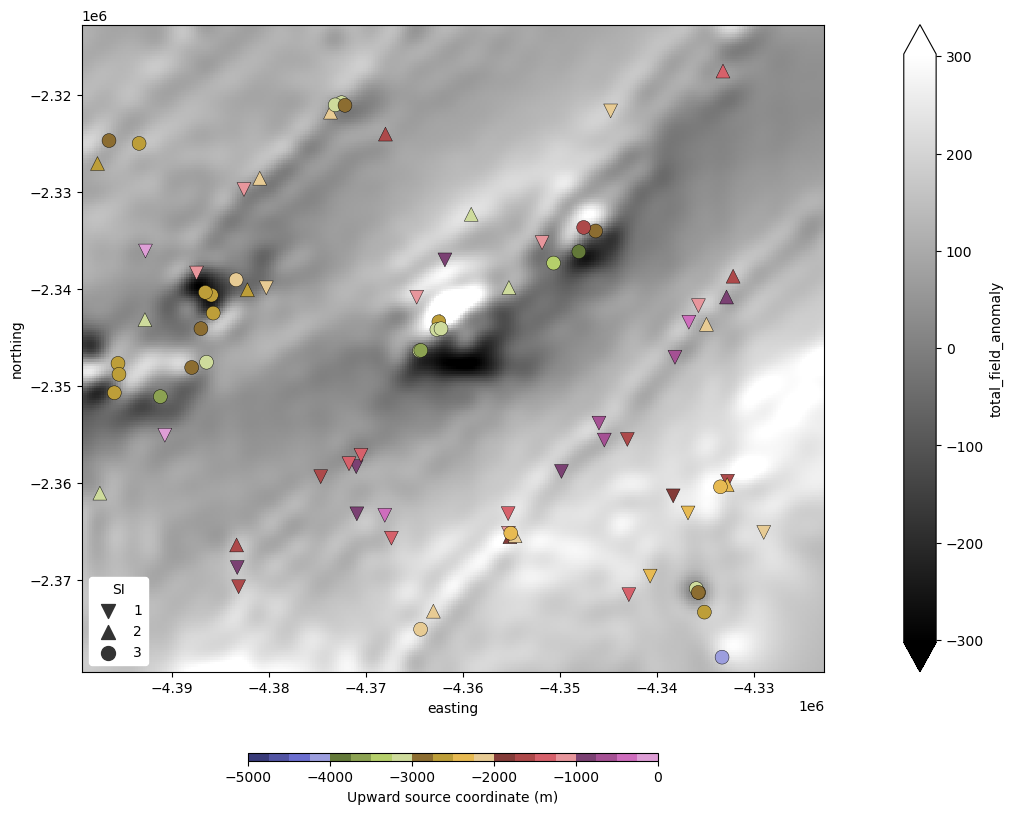

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained")
scale = np.percentile(np.abs(data.total_field_anomaly), 99)
tmp = data.total_field_anomaly.plot(ax=ax, vmin=-scale, vmax=scale, cmap="gray")
ax.set_aspect("equal")
markers = ["v", "^", "o"]
labels = {}
size = 100
vmin, vmax = -5000, 0
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="tab20b",
        #cmap="inferno",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)